In [ ]:
# Standard python libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal

In [ ]:
# Import from a higher directory
import sys
sys.path.append("..")

In [ ]:
# Class to build a neural network in keras
from NeuralNets4OM import Neural_Network
# Class to export neural network to OpenModelica
from NeuralNets4OM import Neural_OM_Model as nom

This dataset can be used to train a neural network to predict the ph of a solution in a tank from acid and base solution flow.
As features u1,u2 are used:
    - u1: Acid solution flow in liters
    - u2: Base solution flow in liters 
As target y is used:
    - y: The ph of a solution in the tank
All of them have a lenght of 2001. The simulation data is of a pH neutralization process in a constant tank volume of 1100 liters. The acid solution concentration was (HAC) 0.0032 Mol/l. The the base solution concentration was (NaOH) 0,05 Mol/l.

In [ ]:
def load_data(train_size):
    input1=pd.read_csv('Data/u1.csv',header=None).to_numpy()
    input2=pd.read_csv('Data/u2.csv',header=None).to_numpy()
    output=pd.read_csv('Data/y.csv',header=None).to_numpy()
    test_size=input1.shape[0]-train_size
    u1_inter=input1[test_size:].reshape(train_size,)
    u2_inter=input2[test_size:].reshape(train_size,)
    y_inter=output[test_size:].reshape(train_size,)
    u1_extra=input1[:test_size].reshape(test_size,)
    u2_extra=input2[:test_size].reshape(test_size,)
    y_extra=output[:test_size].reshape(test_size,)
    return u1_inter, u2_inter, y_inter, u1_extra, u2_extra, y_extra

Load the input and the output data

In [ ]:
u1,u2,y,u1_pre,u2_pre,y_pre=load_data(1800)

Plot the training data

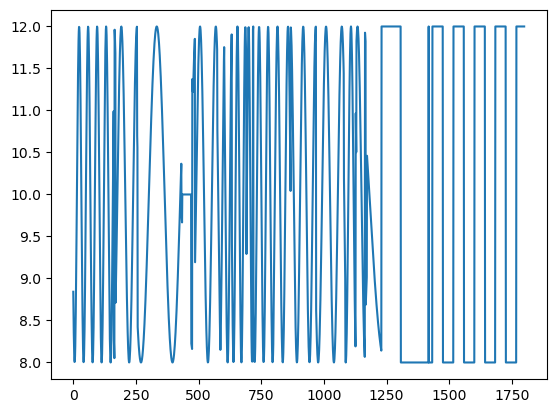

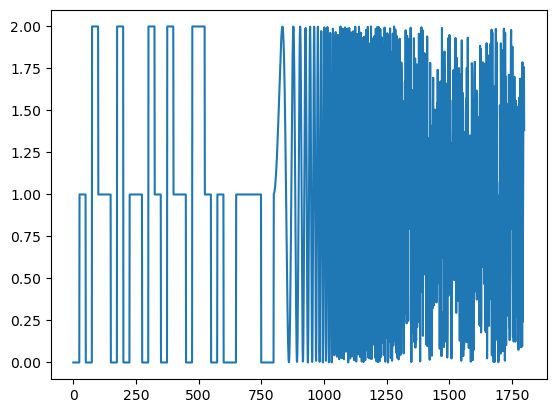

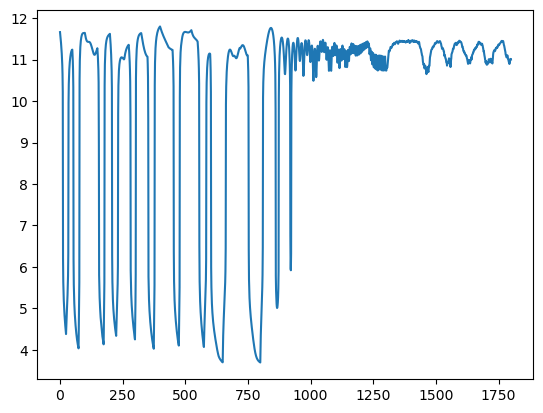

In [ ]:
plt.plot(u1)
plt.show()
plt.plot(u2)
plt.show()
plt.plot(y)
plt.show()

# Preanalysis of the trainingdata

In [ ]:
df_u1=pd.DataFrame(u1)
df_u2=pd.DataFrame(u2)
df_y=pd.DataFrame(y)

                 0
count  1800.000000
mean      9.945081
std       1.603095
min       8.000000
25%       8.180943
50%       9.914177
75%      11.784816
max      12.000000


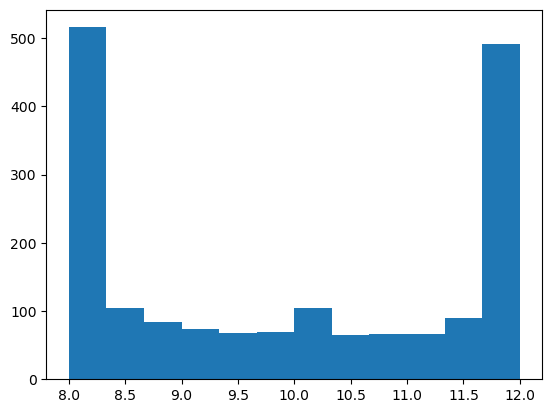

In [ ]:
print(df_u1.describe())
plt.hist(u1, bins='auto')
plt.show()

Outlier detection with mean and median for u1

In [ ]:
pd.DataFrame([df_u1.mean(),df_u1.median()], ["mean","median"])

,0
mean,9.945081
median,9.914177


Outlier detection with 2-sigma-rule

In [ ]:
outlier=np.abs((df_u1._get_numeric_data()-df_u1.mean())/df_u1.std())>2
df_u1._get_numeric_data()[outlier].dropna(how="any")

,0


                 0
count  1800.000000
mean      0.916747
std       0.686598
min       0.000000
25%       0.188962
50%       1.000000
75%       1.469772
max       2.000000


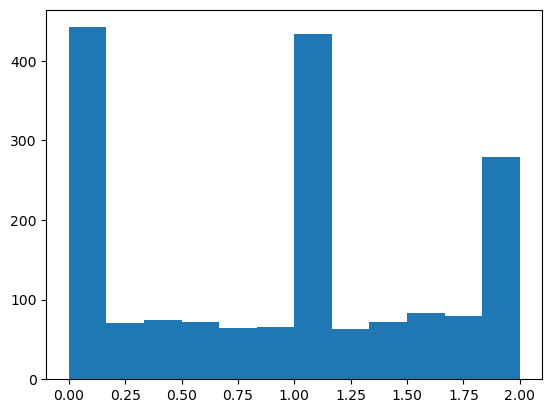

In [ ]:
print(df_u2.describe())
plt.hist(u2, bins='auto')
plt.show()

In [ ]:
pd.DataFrame([df_u2.mean(),df_u2.median()], ["mean","median"])

,0
mean,0.916747
median,1.000000


In [ ]:
outlier=np.abs((df_u2._get_numeric_data()-df_u2.mean())/df_u2.std())>2
df_u2._get_numeric_data()[outlier].dropna(how="any")

,0


                 0
count  1800.000000
mean     10.053728
std       2.528511
min       3.693102
25%      10.857059
50%      11.179525
75%      11.387671
max      11.799612


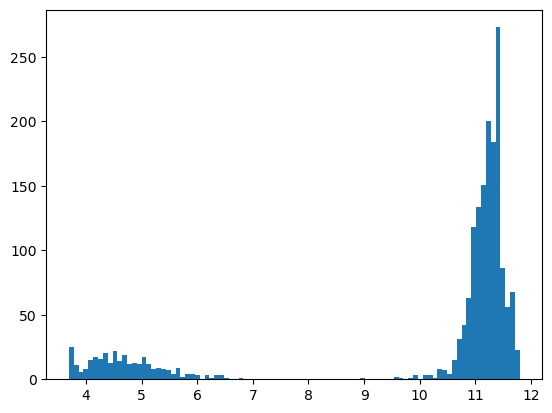

In [ ]:
print(df_y.describe())
plt.hist(y, bins='auto')
plt.show()

In [ ]:
pd.DataFrame([df_y.mean(),df_y.median()], ["mean","median"])

,0
mean,10.053728
median,11.179525


In [ ]:
outlier=np.abs((df_y._get_numeric_data()-df_y.mean())/df_y.std())>3
df_y._get_numeric_data()[outlier].dropna(how="any")

,0


# Generate the delayed feature vectors with an estimated shift based on cross correlation

In [ ]:
def corrfunc(inpt,outpt):
    #Scale input and output respectively to [0,1] for better comparability
    min_in=inpt.min(axis=0)
    max_in=inpt.max(axis=0)
    min_out=outpt.min(axis=0)
    max_out=outpt.max(axis=0)
    i=(inpt-min_in)/(max_in-min_in)
    o=(outpt-min_out)/(max_out-min_out)
    
    plt.plot(i)
    plt.plot(o)
    plt.show()
    # calculate crosscorrelation
    corr=signal.correlate(i,o,mode='full')
    # Normalize the result so that the maximum has the value 1
    corr /= np.max(corr)
    # Function returns an array containing the indices of the forward resp. backward shift,
    # where the index '0' is the one where the two signals are identical
    lags=signal.correlation_lags(len(i), len(o))
    # Find the index maximum value of the cross-correlation and return the associated index shift
    return lags[np.argmax(corr)]

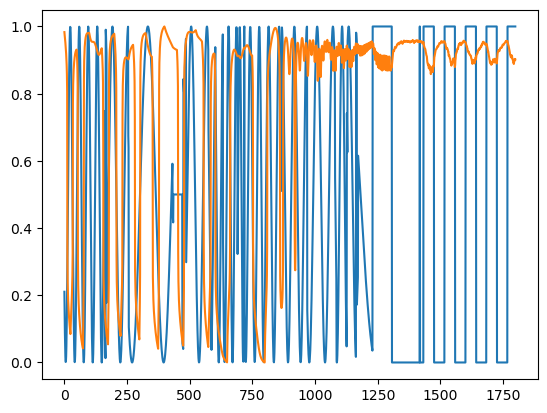

In [ ]:
tau1=corrfunc(u1,y)

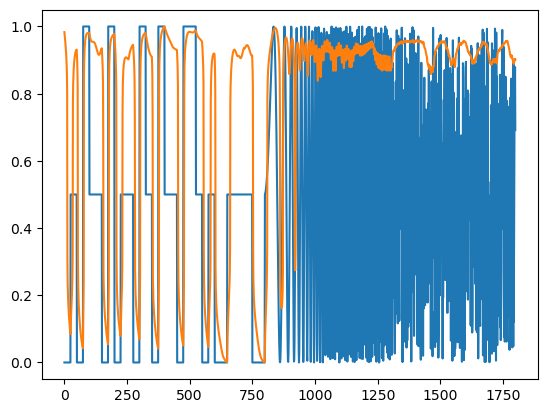

In [ ]:
tau2=corrfunc(u2,y)

In [ ]:
def delay_input(i,d,l):
    # Add current input
    if l==[]:
        l=[i[d:]]
    else:
         l.append(i[d:])
    # Generate delayed inputs and add them to features
    for j in range(1,d+1):
        l.append(i[d-j:-j])
    return l

def delay_output(o,d,l):
    # Generate delayed outputs and add them to features
    for j in range(1,d+1):
        l.append(o[d-j:-j])
    return l

def delay(ipts,opts,delay):
    feature_list=[]
    for i_dim in ipts:
        feature_list=delay_input(i_dim,delay,feature_list)
    for o_dim in opts:
         feature_list=delay_output(o_dim,delay,feature_list)
    return np.stack(feature_list,axis=1)

In [ ]:
tau=min([tau1,tau2])
if tau < 0:
    print("Index shift: {}".format(tau))
    tau*=-1
else:
    print("No identification of delay with crosscorrelation possible!")

Index shift: -4


In [ ]:
features=delay([u1,u2],[y],tau)
targets=y[tau:]

In [ ]:
np.savetxt('test_u1.txt', np.vstack([np.arange(0.0,len(u1_pre[tau:]))*10,u1_pre[tau:]]).T, delimiter=',', newline=';', fmt='%8.8f')
np.savetxt('test_u2.txt', np.vstack([np.arange(0.0,len(u2_pre[tau:]))*10,u2_pre[tau:]]).T, delimiter=',', newline=';', fmt='%8.8f')
np.savetxt('test_y.txt', np.vstack([np.arange(0.0,len(y_pre[tau:]))*10,y_pre[tau:]]).T, delimiter=',', newline=';', fmt='%8.8f')

# Make a PCA to reduce the feature space

In [ ]:
# mu-sigam standardisation
mu=np.mean(features,axis=0)
sigma=np.std(features,axis=0)
X=(features-mu)/sigma

Calculate covariance matrix and sort the eigenvalues in descending order

In [ ]:
Sigma=np.cov(X.T)
(lamb,w)=np.linalg.eig(Sigma)
eigVar=np.sort(lamb)[::-1]

Graphical analysis

In [ ]:
sumEig = np.sum(lamb)
eigVar = eigVar/sumEig
cumVar= np.cumsum(eigVar)

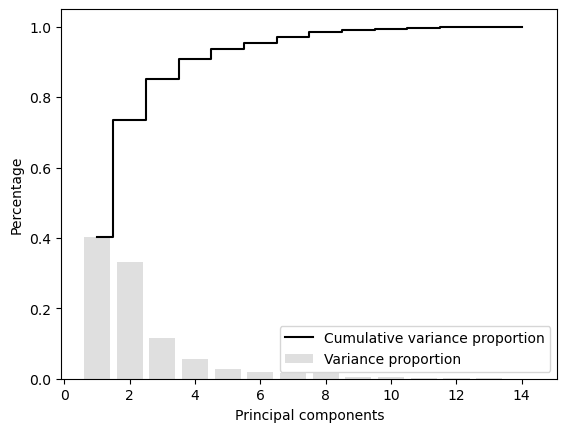

In [ ]:
plt.figure()
plt.bar(range(1,len(eigVar)+1),eigVar, alpha=0.25, align='center',
label='Variance proportion', color='gray')
plt.step(range(1,len(eigVar)+1),cumVar, where='mid',
label='Cumulative variance proportion', c='k')
plt.xlabel('Principal components'); plt.ylabel('Percentage')
plt.legend()
plt.show()

Get the dimension with a good accuracy

In [ ]:
pca_idx=np.argmax(cumVar>0.8)
print(pca_idx)

2


Sort eigenvectors and create a new feature space

In [ ]:
eigenVarIdx=np.argsort(lamb)[::-1]
W=w[:,eigenVarIdx[0:pca_idx]]
features_new=(W.T@X.T).T

# Train the neural network

In [ ]:
#nn = Neural_Network.Neural_Network(features_new,targets)
nn = Neural_Network.Neural_Network(features,targets)

In [ ]:
features_train, features_test, features_max, features_min = nn.scaling(nn.X_train, nn.X_test)

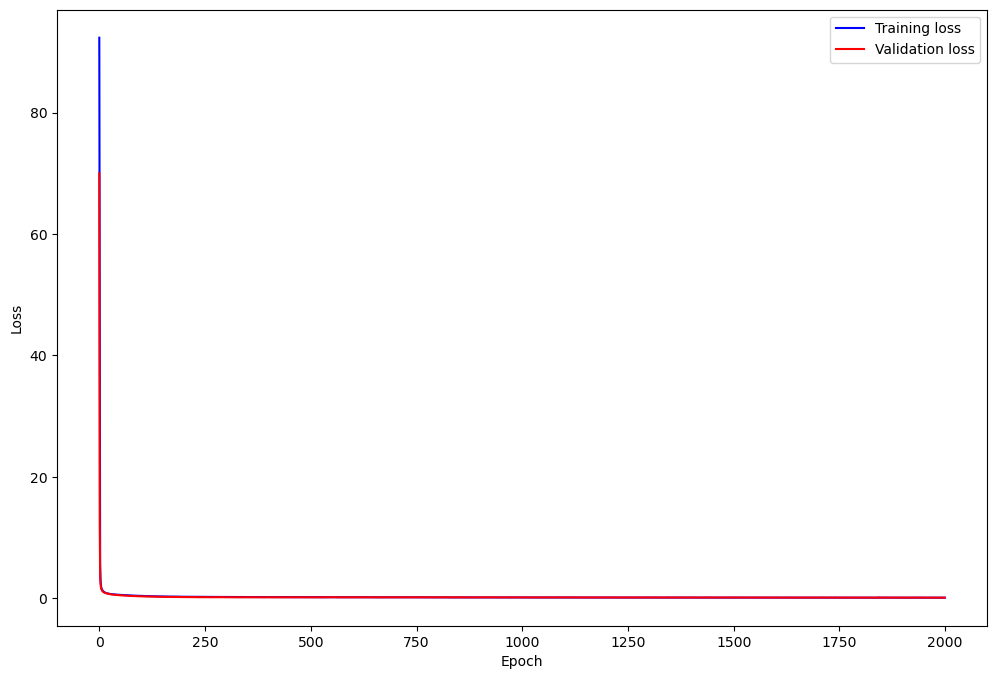

In [ ]:
nn.train(features_train, nn.Y_train)

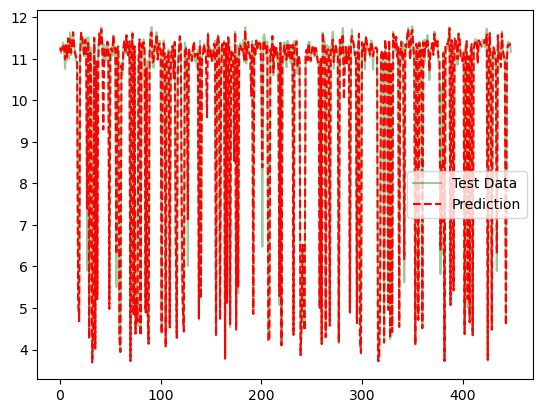

0.11460621479291001


In [ ]:
nn.predict_on_test_data(features_test, nn.Y_test,verbose=True)

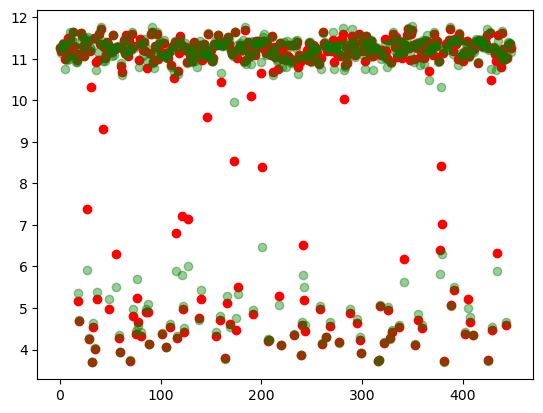

In [ ]:
plt.plot(nn.Y_pred,'ro')
plt.plot(nn.Y_test,'go',alpha=0.4)
plt.show()

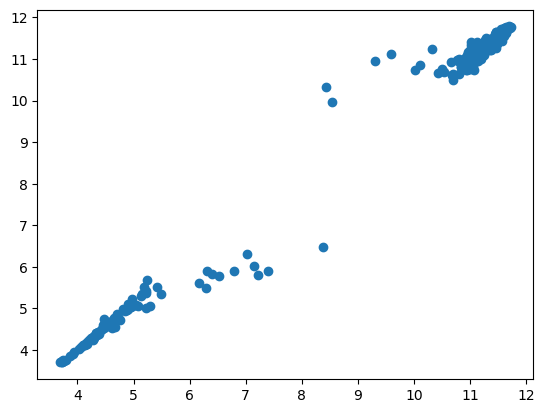

In [ ]:
plt.scatter(nn.Y_pred,nn.Y_test)
plt.show()

In [ ]:
delayed_inputs=delay([u1_pre,u2_pre],[],tau)

In [ ]:
delayed_outputs=np.flip(y_pre[:tau])

In [ ]:
np.savetxt('init_pred.txt', np.concatenate([delayed_inputs[0],delayed_outputs]), delimiter=',', newline=',', fmt='%8.8f')

In [ ]:
# Without PCA
output_net=[]
for i in range(0,delayed_inputs.shape[0]):
    net_in=(np.concatenate([delayed_inputs[i],delayed_outputs])-features_min)/(features_max-features_min)
    net_out=nn.nn.predict(np.array([net_in,])).reshape(-1)
    output_net.append(net_out)
    delayed_outputs=np.roll(delayed_outputs,1)
    delayed_outputs[::tau]=output_net[-1]

In [1]:
# With PCA
output_net=[]
for i in range(0,delayed_inputs.shape[0]):
    f=(np.concatenate([delayed_inputs[i],delayed_outputs])-mu)/sigma
    net_in=((W.T@f.T).T-features_min)/(features_max-features_min)   
    net_out=nn.nn.predict(np.array([net_in,])).reshape(-1) #*(targets_max-targets_min)+targets_min#*targets_std+targets_mean
    output_net.append(net_out)
    delayed_outputs=np.roll(delayed_outputs,1)
    delayed_outputs[::tau]=output_net[-1]

ErrorException: syntax: line break in ":" expression

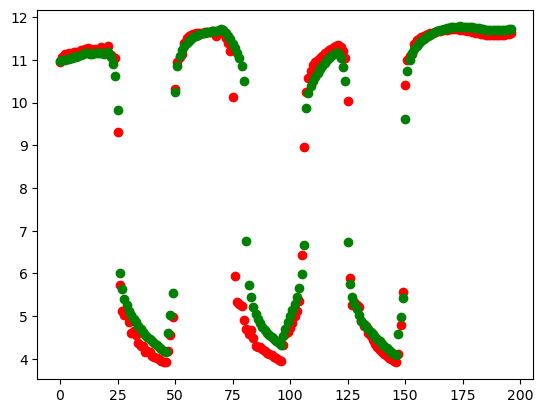

In [ ]:
plt.plot(output_net,'or')
plt.plot(y_pre[tau:],'og')
plt.show()

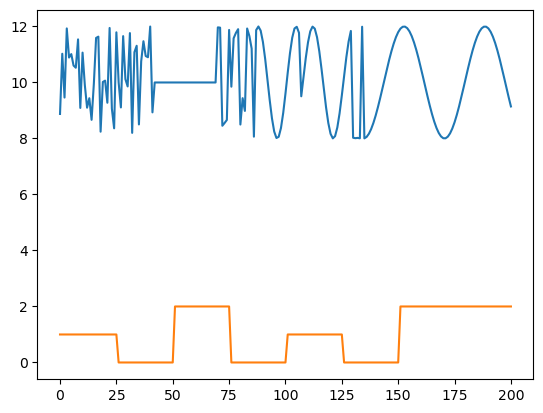

In [ ]:
plt.plot(u1_pre)
plt.plot(u2_pre)
plt.show()

In [ ]:
NeuralOM = nom.Neural_OM_Model(nn.nn, ("false", None, None, None), ("true", features_max, features_min), ("false", None, None), ("false", None, None), ("false", None, None), "NARX_MISO")
NeuralOM.build_OM_Model()

In [ ]:
prediction=np.array(output_net).reshape(197,)

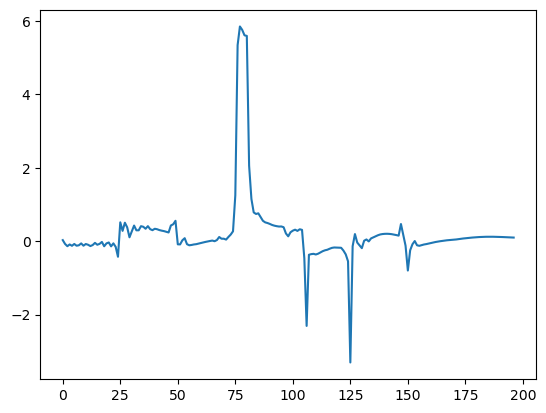

In [ ]:
plt.plot(y_pre[tau:]-prediction)
plt.show()

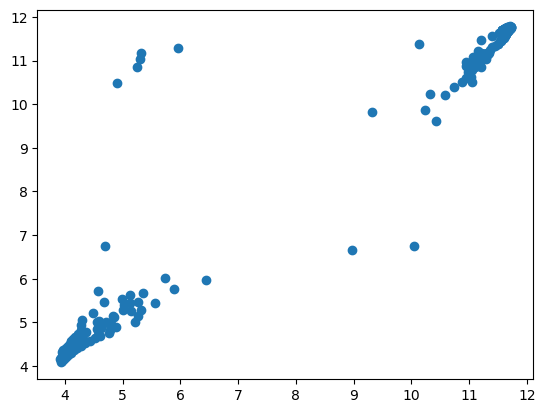

In [ ]:
plt.scatter(prediction,y_pre[tau:])
plt.show()